# Fuzzy C-Means 分类任务

### IRIS 数据集

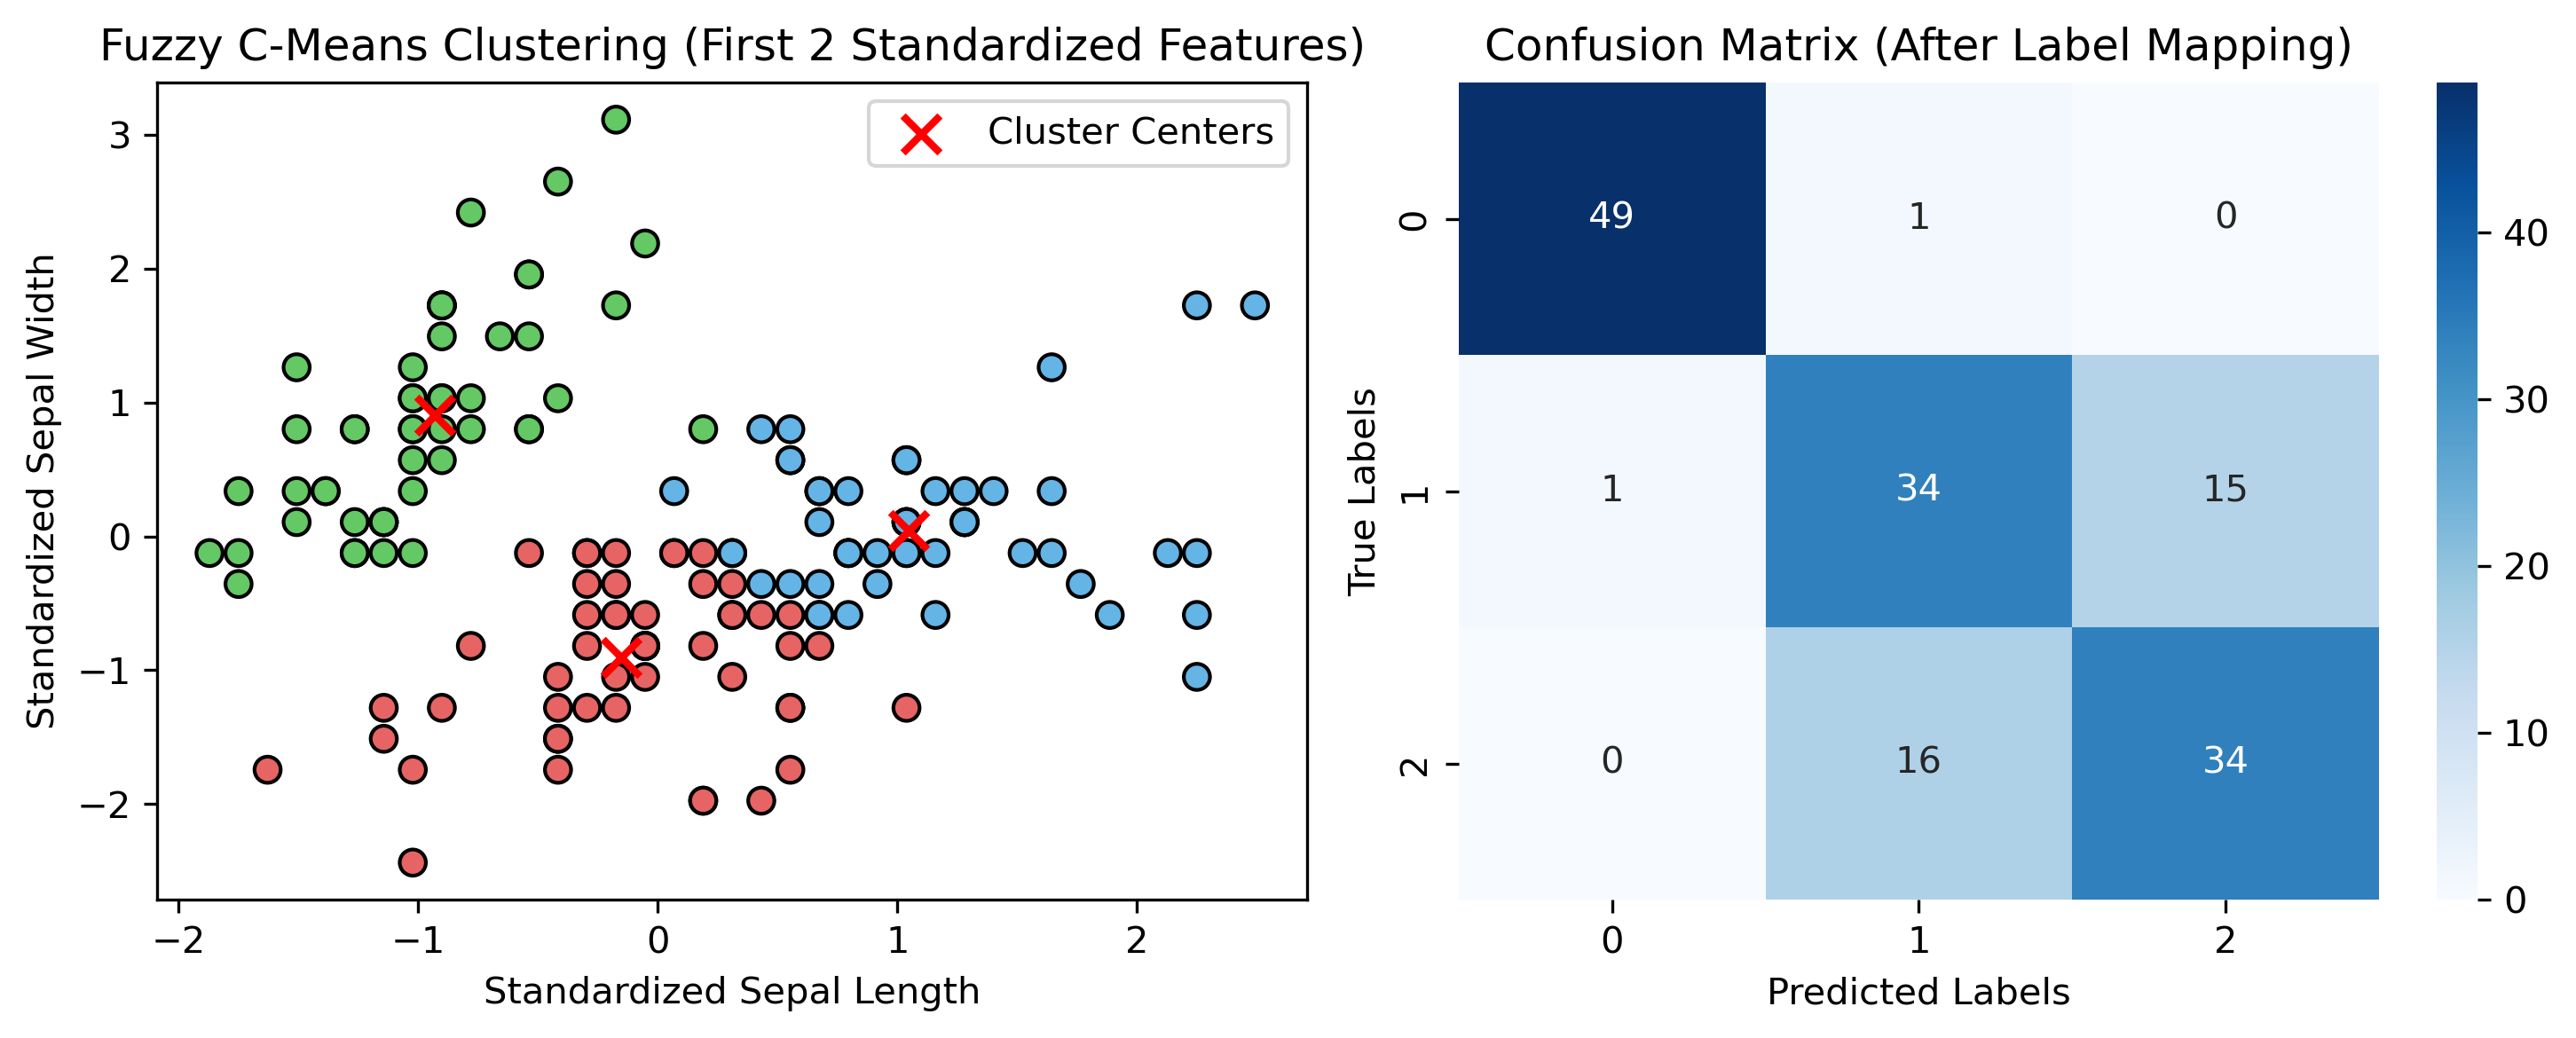

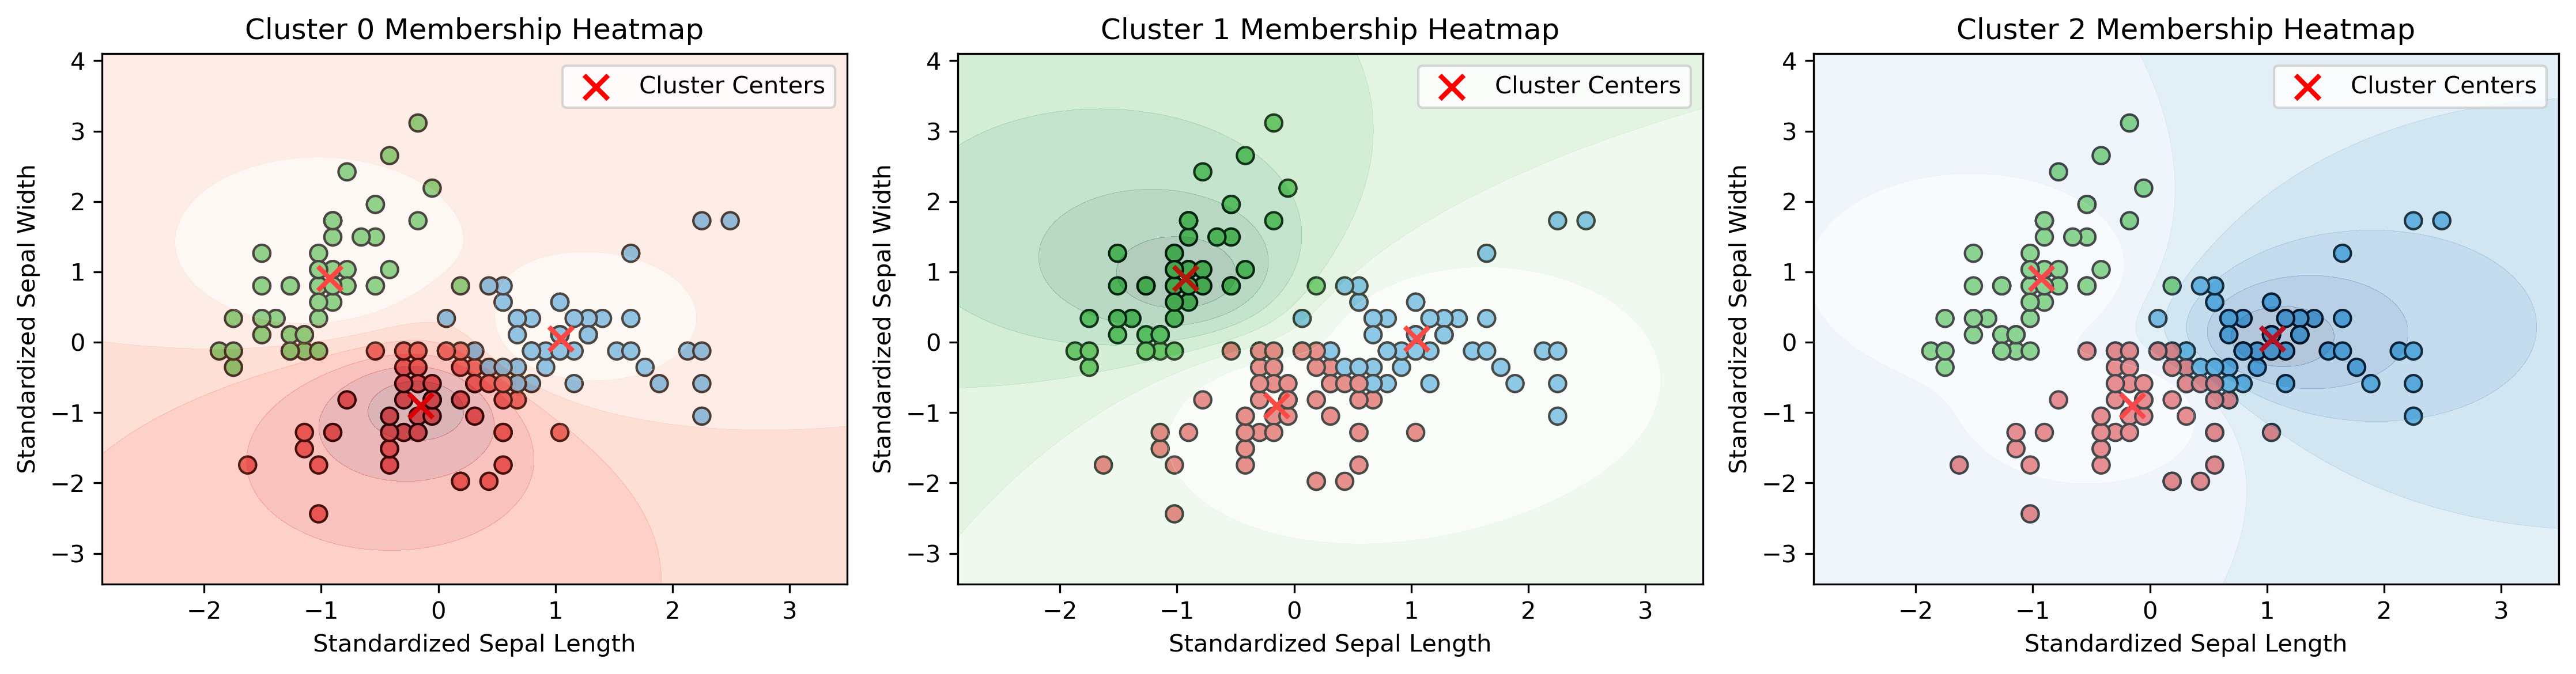

聚类准确率: 0.7800


In [79]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns


# 加载 Iris 数据
def load_iris_data(file_path):
    data = []
    labels = []
    label_mapping = {}
    label_index = 0
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                parts = line.split(',')
                features = [float(x) for x in parts[:-1]]
                label = parts[-1]
                if label not in label_mapping:
                    label_mapping[label] = label_index
                    label_index += 1
                data.append(features)
                labels.append(label_mapping[label])
    return np.array(data), np.array(labels)

# Fuzzy C-Means 算法
def fuzzy_c_means(X, c, m=2, max_iter=100, tol=1e-4):
    n_samples, n_features = X.shape
    # 初始化聚类中心
    centroids = X[np.random.choice(n_samples, c, replace=False)]
    losses = []

    for _ in range(max_iter):
        # 计算距离矩阵
        dist = np.zeros((n_samples, c))
        for i in range(c):
            dist[:, i] = np.linalg.norm(X - centroids[i], axis=1)

        # 计算并更新划分矩阵 U
        U = np.zeros((n_samples, c))
        for j in range(n_samples):
            zero_indices = np.where(dist[j] == 0)[0]
            if len(zero_indices) > 0:
                U[j, zero_indices] = 1
                U[j, np.delete(np.arange(c), zero_indices)] = 0
            else:
                for i in range(c):
                    U[j, i] = 1 / np.sum((dist[j, i] / dist[j]) ** (2 / (m - 1)))

        # 更新聚类中心
        new_centroids = np.zeros((c, n_features))
        for i in range(c):
            numerator = np.sum((U[:, i] ** m)[:, np.newaxis] * X, axis=0)
            denominator = np.sum(U[:, i] ** m)
            new_centroids[i] = numerator / denominator

        # 计算损失
        loss = np.sum((U ** m) * (dist ** 2))
        losses.append(loss)

        # 判断收敛
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    labels = np.argmax(U, axis=1)
    return centroids, labels, losses, U


# 对2D数据进行聚类
c = 3
m = 2
centroids, cluster_labels, losses, U_train = fuzzy_c_means(X_scaled_2d, c, m=m)

# 定义颜色映射
color_map = {0: (230/255, 100/255, 100/255), 1: (100/255, 200/255, 100/255), 2: (100/255, 180/255, 230/255)}
scatter_colors = [color_map[label] for label in cluster_labels]

# 第一张图：左边聚类结果，右边混淆矩阵
plt.figure(figsize=(10, 4), dpi=300)

# 子图1：聚类结果
plt.subplot(1, 2, 1)
plt.scatter(X_scaled_2d[:, 0], X_scaled_2d[:, 1], c=scatter_colors, edgecolor='k', s=50)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, linewidths=2, color='r', label='Cluster Centers')
plt.title('Fuzzy C-Means Clustering (First 2 Standardized Features)')
plt.xlabel('Standardized Sepal Length')
plt.ylabel('Standardized Sepal Width')
plt.legend()

# 子图2：混淆矩阵
plt.subplot(1, 2, 2)
cm_mapped = confusion_matrix(y, mapped_cluster_labels)
sns.heatmap(cm_mapped, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (After Label Mapping)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tight_layout()
plt.show()

# 第二张图：三个类别的热力图
plt.figure(figsize=(15, 4), dpi=300)
cmaps = ['Reds', 'Greens', 'Blues']

for i in range(c):
    plt.subplot(1, 3, i + 1)
    plt.scatter(X_scaled_2d[:, 0], X_scaled_2d[:, 1], c=scatter_colors, edgecolor='k', s=50)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, linewidths=2, color='r', label='Cluster Centers')

    x_min, x_max = X_scaled_2d[:, 0].min() - 1, X_scaled_2d[:, 0].max() + 1
    y_min, y_max = X_scaled_2d[:, 1].min() - 1, X_scaled_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # 计算每个网格点对所有簇的隶属度（模糊 C-Means）
    dist_grid = np.zeros((grid.shape[0], c))
    for j in range(c):
        dist_grid[:, j] = np.linalg.norm(grid - centroids[j], axis=1)
    U_grid = 1 / (dist_grid ** (2 / (m - 1)))
    U_grid = U_grid / np.sum(U_grid, axis=1, keepdims=True)

    # 使用热力图展示隶属度
    plt.contourf(xx, yy, U_grid[:, i].reshape(xx.shape), alpha=0.3, cmap=cmaps[i])
    plt.title(f'Cluster {i} Membership Heatmap')
    plt.xlabel('Standardized Sepal Length')
    plt.ylabel('Standardized Sepal Width')
    plt.legend()

plt.tight_layout()
plt.show()

# 输出聚类准确率
accuracy = accuracy_score(y, mapped_cluster_labels)
print(f'聚类准确率: {accuracy:.4f}')

##### 加载数据集

##### 数据预处理

##### Fuzzy C-Means Clustering

##### 结果

### Wine数据集

### Seeds数据集